# Run Commands to generate data

In [50]:
!conda env list
!conda activate hnr23

# conda environments:
#
base                     C:\ProgramData\Miniconda3
deep-cuda                C:\Users\iycsp\.conda\envs\deep-cuda
focal                    C:\Users\iycsp\.conda\envs\focal
hacknroll23              C:\Users\iycsp\.conda\envs\hacknroll23
hnr23                 *  C:\Users\iycsp\.conda\envs\hnr23
pytorch3d                C:\Users\iycsp\.conda\envs\pytorch3d



In [51]:
!python --version
!which python

Python 3.7.15
/c/Users/iycsp/.conda/envs/hnr23/python


In [52]:
!python capturer.py 10 ./logs/2

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import mediapipe as mp

import sys
import json

# Understand Pose Data

In [53]:
def get_df(input_path):
    input_file = open(input_path)
    data = json.load(input_file)
    df = pd.DataFrame(data)
    df['idx'] = df.index
    return df

In [54]:
df_loc = get_df("./logs/2_local.json")
df_glo = get_df("./logs/2_global.json")

In [42]:
def scatter_pose(df, fig_size=(8, 8)):
    plt.figure(figsize=fig_size)
    plt.scatter(df['x'].tolist(), df['y'].tolist())

    df.apply(lambda row:
        plt.annotate(row['idx'], (row['x'], row['y'])), axis=1)
    plt.show()

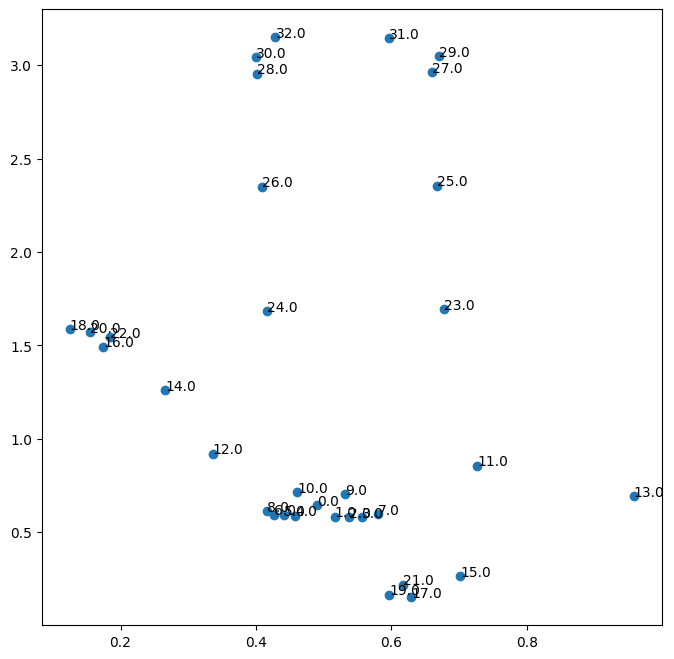

In [61]:
# full
scatter_pose(df_loc)

In [48]:
df[(df['idx'] == 15) | (df['idx'] == 16)]

,x,y,z,vis,idx
15,0.913793,1.580258,-1.013870,0.068619,15
16,0.177834,1.621891,-1.342331,0.111872,16


In [56]:
df_glo.head()

,x,y,z,vis,idx
0,-0.037364,-0.583402,-0.246627,0.999913,0
1,-0.027706,-0.617450,-0.240648,0.999854,1
2,-0.027059,-0.618048,-0.240080,0.999853,2
3,-0.027677,-0.619017,-0.241537,0.999821,3
4,-0.055867,-0.610364,-0.230754,0.999855,4


In [57]:
df_loc.head()

,x,y,z,vis,idx
0,0.489652,0.643793,-0.920491,0.999913,0
1,0.516367,0.584219,-0.866419,0.999854,1
2,0.537684,0.582309,-0.866331,0.999853,2
3,0.556020,0.580839,-0.866163,0.999821,3
4,0.457921,0.589581,-0.851181,0.999855,4


(array([10.,  0.,  3.,  2.,  0.,  0.,  0.,  0.,  0., 18.]),
 array([3.81219688e-05, 1.00025560e-01, 2.00012998e-01, 3.00000435e-01,
        3.99987873e-01, 4.99975311e-01, 5.99962749e-01, 6.99950187e-01,
        7.99937625e-01, 8.99925063e-01, 9.99912500e-01]),
 <BarContainer object of 10 artists>)

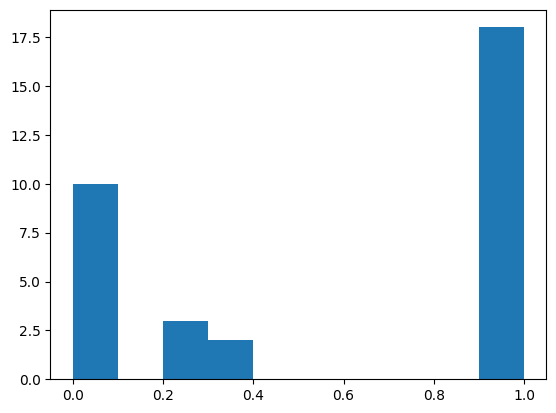

In [60]:
plt.hist(df_glo['vis'])

## Track Hand Movement
- The movement is wrt. the wrist. 
- Define the hand position as the arithematic mean of the hand thumb, pinky and index (if present).
- A hand is present if both the hand wrist and {at least one of the thumb, pinky, and index} are present.

Specifications:
- Left Hand: `15` wrist, `17` thumb, `19` pinky, `21` index.
- Right Hand: `16` wrist, `18` thumb, `20` pinky, `22` index.

Others
- Obtain the min z-coordinate value for future development on scaling

In [95]:
const_wrist_idx = [15, 16]
const_hand_idx = [
    [17, 19, 21],
    [18, 20, 22]
]
const_hand_names = ['left', 'right']
const_vis_threshold = 0.05

def get_hand_movement(df):
    df_present = df[df['vis'] > const_vis_threshold].reset_index()
    
    res = []
    for i in range(2):
        hand = const_hand_names[i]
        if const_wrist_idx[i] not in df_present['idx'].tolist():
            continue
        
        df_curr_hand = df_present[df_present['idx'].isin(const_hand_idx[i])]
        if df_curr_hand.shape[0] == 0:
            continue
        
        # wrist and at least one hand keypoint present
        y_diff = df_curr_hand['y'].mean() - df_present[df_present['idx'] == const_wrist_idx[i]]['y'].mean()
        z_mean = df_present[(df_present['idx'].isin(const_hand_idx[i])) | (df_present['idx'] == const_wrist_idx[i])]['z'].mean()
        res.append( (hand, y_diff, z_mean) )
    
    return res

In [96]:
get_hand_movement(df)

[('left', 0.07187330722808838, -1.133319914340973),
 ('right', 0.07124320665995287, -1.5068879425525665)]

In [75]:
df.describe().round(2)

,x,y,z,vis,idx
count,33.00,33.00,33.00,33.00,33.00
mean,0.52,1.58,-0.79,0.43,16.00
std,0.23,0.96,0.51,0.46,9.67
min,0.16,0.54,-1.70,0.00,0.00
25%,0.39,0.62,-1.15,0.01,8.00
50%,0.49,1.62,-1.01,0.16,16.00
75%,0.67,1.83,-0.36,1.00,24.00
max,0.94,3.31,0.07,1.00,32.00


In [82]:
df[df['vis'] >0.5].describe().round(2)

,x,y,z,vis,idx
count,13.00,13.00,13.00,13.00,13.00
mean,0.50,0.64,-0.94,0.99,6.00
std,0.12,0.14,0.31,0.02,3.89
min,0.30,0.54,-1.22,0.94,0.00
25%,0.44,0.56,-1.15,1.00,3.00
50%,0.49,0.57,-1.14,1.00,6.00
75%,0.55,0.69,-0.69,1.00,9.00
max,0.78,0.96,-0.35,1.00,12.00
